# MAESTRO Dataset
Mouais

## Pre-process
Pas utile si `data/piece0.csv` existe déjà 

In [1]:
import pandas as pd
from music21 import converter
import music21
from tqdm.autonotebook import tqdm
from IPython.core.display import HTML

class PieceDataFrame:
    
    def __init__(self, filename):
        
        assert "musicxml" in filename, "WARNING : not musicXML file !"
        
        self.data = {
            'note' : [],
            'velocity' : [],
            'time_symb' : [],
            'pitch' : [],
            'hand' : [],
            'time_wav' : []
        }
        
        print("Parsing musicxml...")
        self.score = converter.parse(filename)
        self.n_bar = len(self.score.recurse(classFilter='Measure'))
        self.metro_mark = float(list(self.score.recurse(classFilter="MetronomeMark"))[0].durationToSeconds(1))
        self.df = None
        self.make_df()
        
    
    def update_data(self, note, offset, hand):
        self.data['note'].append(note.pitch.midi)
        self.data['velocity'].append(note.volume.velocity)
        self.data['time_symb'].append(offset)
        self.data['pitch'].append(note.pitch)
        self.data['hand'].append(hand)
        self.data['time_wav'].append(float(offset) * self.metro_mark)
        

    def make_df(self):
        pbar = tqdm(total=self.n_bar, desc="Analyzing...")
        for part_staff in self.score.recurse(classFilter=['PartStaff']):
            
            this_hand = "R" if "Staff1" in part_staff.id else "L"
            
            for measure in part_staff.recurse(classFilter=['Measure']):
                for elt in measure.recurse(classFilter=['Note', 'Chord']):
                    if isinstance(elt, music21.note.Note):
                        this_offset = elt.offset + measure.offset
                        self.update_data(elt, this_offset, this_hand)

                    elif isinstance(elt, music21.chord.Chord):
                        for note in elt:
                            this_offset = elt.offset + measure.offset
                            self.update_data(note, this_offset, this_hand)
                pbar.update(1)
        pbar.close()
        
        self.df = pd.DataFrame(self.data)
        self.df = self.df.sort_values(by='time_symb', ignore_index=True)
        
    
    def get_dataframe(self):
        return self.df
    
    
    def display_notebook(self):
        display(HTML(self.df.to_html()))
        
    def get_score(self):
        return self.score
    
    def export_to_csv(self, filename):
        self.df.to_csv(filename, index=False)
        print(f"Exported to {filename}")
    
    
    

<ipython-input-1-a40fc4bdbddd>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
filename = 'data/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.musicxml'
piece0 = PieceDataFrame(filename)

Parsing musicxml...


In [3]:
piece0.export_to_csv('data/piece0.csv')

Exported to piece0.csv


## Inject

In [23]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client import InfluxDBClient, Point, WriteOptions
import rx
from rx import operators as ops
from collections import OrderedDict
from csv import DictReader
from datetime import datetime

In [28]:
bucket = "maestro"
org = "obd_influxdb"
token = "DkqpJF-KB6oCD25k7E8woeHxK0deggIpNyDxFeoszhLogSRrYLKdYMdcZjVGXyutwFSFBfLD5-Jkbah6wt9ujA=="
url="http://localhost:8086"

client = influxdb_client.InfluxDBClient(
        url=url,
        token=token,
        org=org,
        timeout=60_000
    )

In [36]:
df = pd.read_csv('data/piece0.csv')
pbar = tqdm(total=len(df))
write_api = client.write_api(write_options=SYNCHRONOUS)

    
for i, row in df.iterrows():
    #Format 2021-10-06T20:05:38Z
    # Fields are data, Tags are metadata
    this_time = datetime.utcfromtimestamp(row['time_wav']).strftime('%Y-%m-%dT%H:%M:%S.%fZ')
    p = influxdb_client.Point("piece0") \
        .tag("note", row['note']) \
        .field("velocity", row['velocity']) \
        .field("hand", int(row['hand'] == 'R')) \
        .time(this_time)
    write_api.write(bucket=bucket, org=org, record=p, time_precision="ms")
    pbar.update(1)
pbar.close()

In [35]:
def delete_db():
    delete_api = client.delete_api()
    start = "1970-01-01T00:00:00Z"
    stop = "2022-02-01T00:00:00Z"
    delete_api.delete(start, stop, '_measurement="piece0"', bucket=bucket, org=org)
    print("Done !")
    
delete_db()

Done !


---
Quick query :

<code>from(bucket:"maestro")
  |> range(start: 0, stop: now())</code>

**Dashboard**

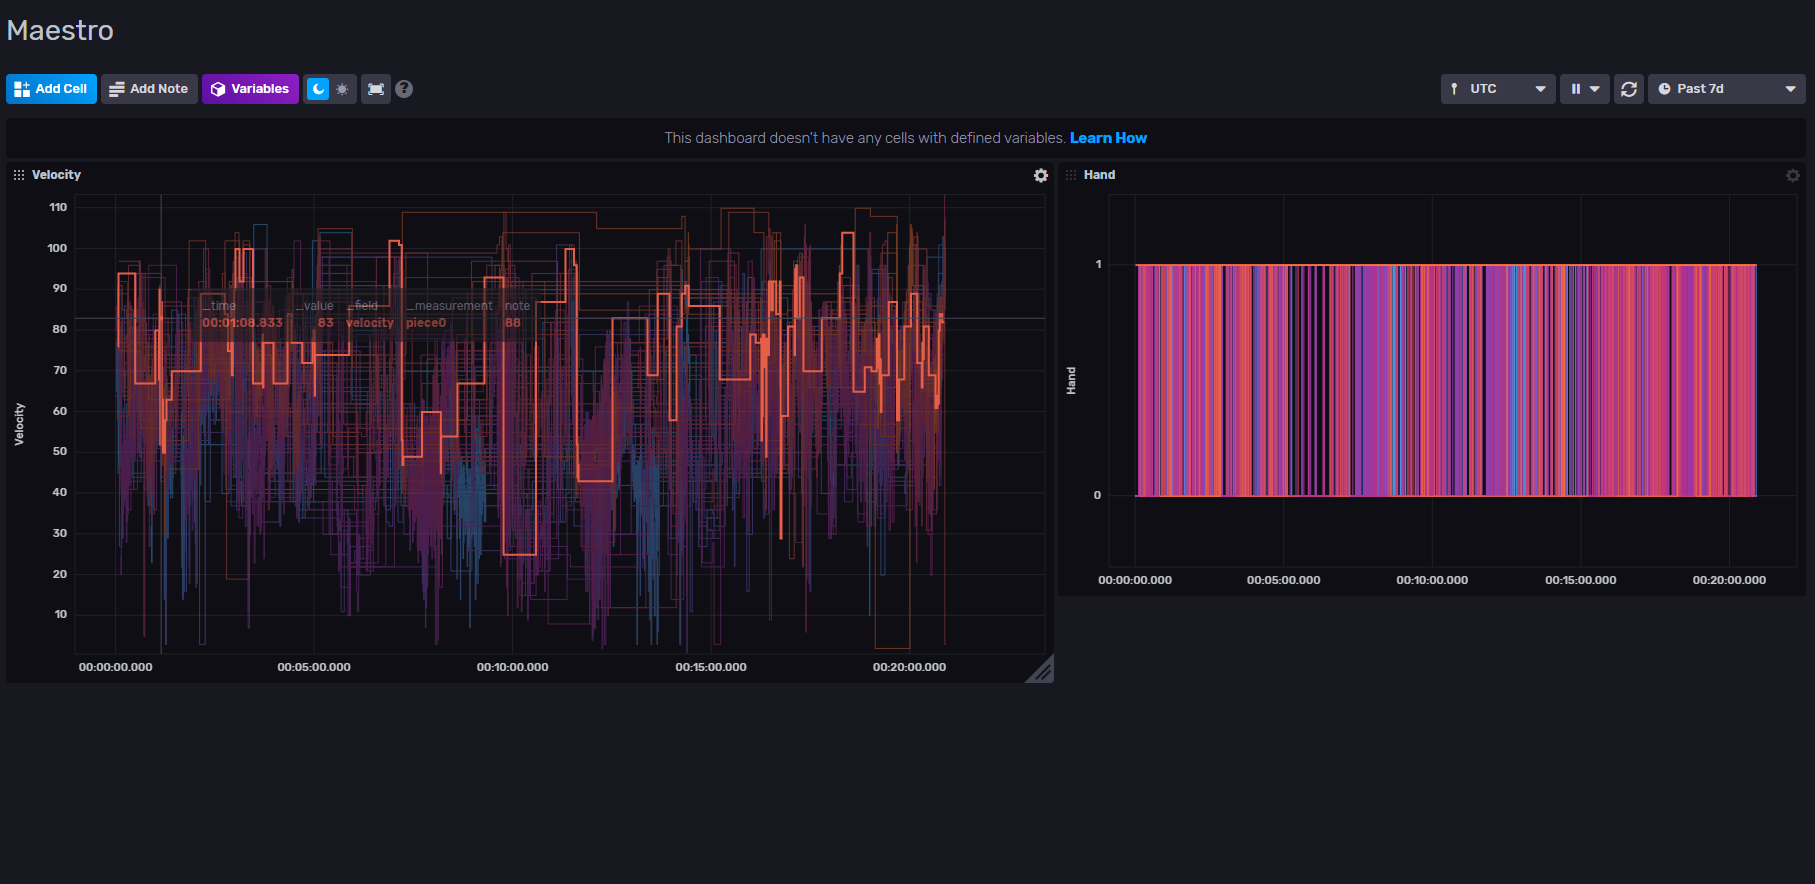

## Playground

In [19]:
df_piece0 = piece0.get_dataframe()
df_piece0.groupby('note').count()

,velocity,time_symb,pitch,hand,time_wav
note,,,,,
28,3,3,3,3,3
29,62,62,62,62,62
30,28,28,28,28,28
31,89,89,89,89,89
32,25,25,25,25,25
...,...,...,...,...,...
93,77,77,77,77,77
94,19,19,19,19,19
95,23,23,23,23,23
